# MNIST 이용하여 복잡한 토폴리지 CNN 모델링 만들기
+ 본과정에서는 Functional API 사용하여 입력 1개, 출력 2개가 되도록 CNN 모델링 합니다.
+ 여러분이 여러개의 입력과 출력이 되는 모델을 구성하려면 반드시 Functional API 사용할줄 알아야 됩니다.

### 학습목차
1. Import modules
2. 데이터 불러오기 : Keras Dataset MNIST 활용
3. y레이블을 보고 홀수/짝수 레이블 만들기
4. Functional API 이용하여 1개 입력, 2개 출력 모델(숫자(0~9), 홀수/짝수 예측)
5. 모델 Compile
6. 학습 수행 : model.fit , EarlyStopping , ModelCheckpoint
7. 학습 결과 테스트 : model.evaluate
8. 성능 그래프
9. 설전 테스트 : 손글씨 입력해서 분류 잘하는지 보기

## 1. Import modules

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. 데이터 불러오기

In [2]:
# MNIST 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## 3. y레이블을 보고 홀수/짝수 레이블 만들기

In [3]:
# Train 레이블의 숫자를 보고 짝수(0), 홀수(1)로 나누기

y_train_odd = []
for y in y_train:
    if y % 2 == 0:
        y_train_odd.append(0)
    else:
        y_train_odd.append(1)

y_train_odd = np.array(y_train_odd)
y_train_odd.shape

(60000,)

In [4]:
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


In [5]:
# Test 레이블의 숫자를 보고 짝수(0), 홀수(1)로 나누기

y_test_odd = []
for y in y_test:
    if y % 2==0:
        y_test_odd.append(0)
    else:
        y_test_odd.append(1)

y_test_odd = np.array(y_test_odd)
y_test_odd.shape

(10000,)

In [6]:
# 정규화(Normalization)
x_train = x_train / 255.0
x_test = x_test / 255.0

# 채널 추가 : reshape, tf.newaxis, expand_dims  이용 가능
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)

print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


## 4. Functional API 이용하여 1개 입력, 2개 출력 모델(숫자(0~9), 홀수/짝수 예측)
- 입력 1 : 이미지 (28 X 28)
- 출력 1 : 0 ~ 9 까지 숫자 예측
- 출력 2: 각 숫자가 홀수인지 짝수인지 예측

![Mnist](https://github.com/gzone2000/TEMP_TEST/raw/master/mnist_multi_input_output.PNG)

In [7]:
# Functional API를 사용하여 모델 생성
# 입력과 출력 레이어에 이름 붙여주자!!!
# 입력 1개 : 이미지 (28 X 28)
# 출력 2개
# 1) 홀짝 분류 : 이미지 > Flatten
# 2) 0~9 숫자 분류 : 이미지 > CNN > Flatten > concat (홀짝 Flatten + CNN Flatten) > DNN


# 입력
inputs = tf.keras.layers.Input(shape=(28, 28, 1), name='inputs')

# 컨볼루션
conv = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_layer')(inputs)
pool = tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_layer')(conv)
flat = tf.keras.layers.Flatten(name='flatten_layer')(pool)

# concat
flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])

# 출력
digit_outputs = tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat)
odd_outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs)

# 모델
model = tf.keras.models.Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_layer (Conv2D)       (None, 26, 26, 32)           320       ['inputs[0][0]']              
                                                                                                  
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)           0         ['conv2d_layer[0][0]']        
 D)                                                                                               
                                                                                                  
 flatten_layer (Flatten)     (None, 5408)                 0         ['maxpool_layer[0][0]']   

In [8]:
# 모델의 입력과 출력을 나타내는 텐서
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'digit_dense')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'odd_dense')>]


In [10]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_output_cnn.png')

![multi_layer](https://github.com/gzone2000/TEMP_TEST/raw/master/BB/multi_output_cnn.png)

## 5. 모델 Compile

In [11]:
# 모델 컴파일
# loss : 딕셔러니 형태로 출력 레이어 이름에 loss 매핑
# loss_weight로 각 loss에 가중치 부여

model.compile(optimizer='adam',
              loss={'digit_dense': 'sparse_categorical_crossentropy', 'odd_dense': 'binary_crossentropy'},
              loss_weights={'digit_dense': 1, 'odd_dense': 0.5}, # loss = 1.0 *sparse_categorical_crossentropy + 0.5*binary_crossentropy
              metrics=['accuracy'])

## 6. 학습 수행


In [12]:
# 입력, 출력 : 딕셔러니 형태로 {레이어 이름 : 데이터셋} 포맷으로 주어야 함.
history = model.fit(x={'inputs': x_train}, y={'digit_dense': y_train, 'odd_dense': y_train_odd},
                    validation_data=({'inputs': x_test},  {'digit_dense': y_test, 'odd_dense': y_test_odd}),
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 19s 5ms/step - loss: 0.3676 - digit_dense_loss: 0.2059 - odd_dense_loss: 0.3235 - digit_dense_accuracy: 0.9408 - odd_dense_accuracy: 0.8650 - val_loss: 0.2263 - val_digit_dense_loss: 0.0885 - val_odd_dense_loss: 0.2756 - val_digit_dense_accuracy: 0.9736 - val_odd_dense_accuracy: 0.8866
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2159 - digit_dense_loss: 0.0803 - odd_dense_loss: 0.2712 - digit_dense_accuracy: 0.9768 - odd_dense_accuracy: 0.8920 - val_loss: 0.2000 - val_digit_dense_loss: 0.0686 - val_odd_dense_loss: 0.2629 - val_digit_dense_accuracy: 0.9786 - val_odd_dense_accuracy: 0.8956
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1918 - digit_dense_loss: 0.0606 - odd_dense_loss: 0.2624 - digit_dense_accuracy: 0.9816 - odd_dense_accuracy: 0.8960 - val_loss: 0.1916 - val_digit_dense_loss: 0.0610 - val_odd_dense_loss: 0.2612 - val_digit_dense_accuracy: 0.9809 - val_

## 7. 학습 결과 테스트

In [13]:
# 입력/출력 : 딕셔러니 형태로 {레이어 이름 : 데이터셋} 포맷으로 주어야 함.
model.evaluate({'inputs': x_test}, {'digit_dense': y_test, 'odd_dense': y_test_odd})

313/313 [==============================] - 2s 5ms/step - loss: 0.1850 - digit_dense_loss: 0.0568 - odd_dense_loss: 0.2565 - digit_dense_accuracy: 0.9843 - odd_dense_accuracy: 0.9000


[0.18501903116703033,
 0.05677226558327675,
 0.256493479013443,
 0.9843000173568726,
 0.8999999761581421]

## 8. 성능 그래프

In [14]:
history.history.keys()

dict_keys(['loss', 'digit_dense_loss', 'odd_dense_loss', 'digit_dense_accuracy', 'odd_dense_accuracy', 'val_loss', 'val_digit_dense_loss', 'val_odd_dense_loss', 'val_digit_dense_accuracy', 'val_odd_dense_accuracy'])

In [15]:
x_range = range(1,len(history.history['digit_dense_accuracy'])+1)

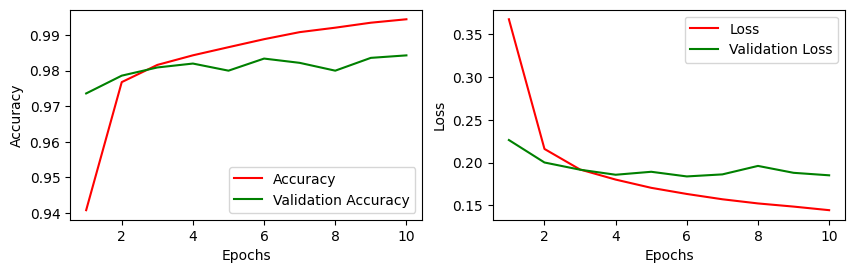

In [16]:
# Accuracy와 Loss에 대한 2개의 subplot 그림

plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(x_range, history.history['digit_dense_accuracy'], color='red', label='Accuracy')
plt.plot(x_range, history.history['val_digit_dense_accuracy'], color='green', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(222)
plt.plot(x_range, history.history['loss'], color='red', label='Loss')
plt.plot(x_range, history.history['val_loss'], color='green', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## 9. 실전 테스트

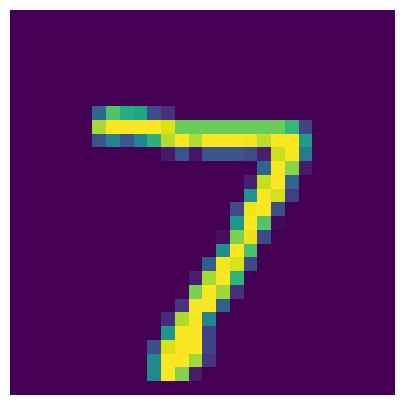

In [17]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.squeeze(data[idx]))
    plt.axis("off")
    plt.show()

plot_image(x_test, 0)

In [18]:
# 출력 2개 : 0~9 예측, 홀수/짝수 예측
digit_preds, odd_preds = model.predict(x_test)
print(digit_preds[0])
print(odd_preds[0])

313/313 [==============================] - 1s 2ms/step
[7.0107115e-14 5.4594953e-12 2.3654578e-10 5.2684959e-07 5.2211855e-12
 6.6359033e-13 1.2549896e-21 9.9999952e-01 4.0449405e-10 1.8782274e-08]
[0.99964]


In [19]:
# 숫자 0 ~ 9 예측
digit_labels = np.argmax(digit_preds, axis=-1)
digit_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [20]:
# 홀수/짝수 예측 : 짝수 0, 홀수 1
odd_labels = np.where(odd_preds>0.5 , 1, 0).reshape(-1)
odd_labels[0:10]

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 1])

## 배운 내용 정리
1. Functional API 사용하여 1개 입려과 2개 출력하는 CNN 모델 구성하였으며
2. 이를 통해서 Functional API 사용하여 복잡한 토폴로지 형태의 모델 만들수 있게 되었습니다.
3. 특히, 여러개의 output 예측할 경우, loss function과 모델 fit 학습시 주의해서 인자값들을 입력을 해 주어야 합니다.
2. 백문이 불여일타 : 반복 사용하여 익숙해 졌으면 좋겠습니다.